In [1]:
from importlib import reload
import sys
sys.path.insert(0, '../')

# sys.path.remove("/home/users/yixiuz/.local/lib/python3.9/site-packages")
sys.path.append("/home/groups/swl1/yixiuz/torch_fid/lib/python3.9/site-packages")
sys.path.append("/home/groups/swl1/yixiuz/torch_fid/bin")

In [2]:
# %env TORCH_USE_CUDA_DSA 1
# %env CUDA_LAUNCH_BLOCKING 1

In [3]:
# reload(sampling_utils)
# reload(sampling)
# reload(eval_config)
# reload(model_utils)
# reload(models)
# reload(dataset_utils)
# reload(datasets)
# reload(eval_config)

In [4]:
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import ml_collections

# import config.eval.countdown as eval_config
import config.eval.genes as eval_config

import lib.utils.bookkeeping as bookkeeping
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import lib.utils.utils as utils
import lib.models.models as models
import lib.models.model_utils as model_utils
import lib.datasets.datasets as datasets
import lib.datasets.dataset_utils as dataset_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils

%matplotlib inline

eval_cfg = eval_config.get_config()
train_cfg = bookkeeping.load_ml_collections(Path(eval_cfg.train_config_path))

for item in eval_cfg.train_config_overrides:
    utils.set_in_nested_dict(train_cfg, item[0], item[1])

S = train_cfg.data.S
device = torch.device(eval_cfg.device)
# device = torch.device('cpu')

model = model_utils.create_model(train_cfg, device)

loaded_state = torch.load(Path(eval_cfg.checkpoint_path),
    map_location=device)

modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
model.load_state_dict(modified_model_state)

model.eval()

dataset = dataset_utils.get_dataset(eval_cfg, device)
data = dataset.data
# test_dataset = np.load(eval_cfg.sampler.test_dataset)

# descrambled_test_dataset = descramble(test_dataset)

2024-05-19 15:46:18.071301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 15:46:18.185857: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /share/software/user/open/cudnn/8.9.0.131/lib:/usr/lib64/nvidia:/share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib:/share/software/user/open/cuda/12.2.0/lib64:/share/software/user/open/cuda/12.2.0/nvvm/lib64:/share/software/user/open/cuda/12.2.0/extras/Debugger/lib64:/share/software/user/open/cuda/12.2.0/extras/CUPTI/lib64:/share/software/user/open/python/3.9.0/lib:/share/software/u

In [5]:
def count_mistakes(samples):
    """
    sample: (N, L, S)
    """
    num_positions = samples.shape[0] * samples.shape[1]
    return (np.sum(((samples[:,:-1] - samples[:,1:]) != 1) * (samples[:,:-1] != 0))) / num_positions

def visualize_diff(ax, x, y):
    x_mat = F.one_hot(torch.tensor(x), S).T
    y_mat = F.one_hot(torch.tensor(y), S).T
    img = torch.stack([x_mat, y_mat, x_mat * y_mat], axis=2)
    ax.imshow(img * 255)

In [8]:
from scipy.stats import skew, kurtosis

def eval_mse_stats(dataset, samples):
    
    true_samples = dataset.data.cpu().numpy()
    samples = np.clip(samples, 0, S-2)

    true_samples_scaled = dataset.rescale(true_samples)
    samples_scaled = dataset.rescale(samples)

    out = {
        "mean": np.mean(
            (np.mean(samples_scaled, axis=0) 
           - np.mean(true_samples_scaled, axis=0))**2
        ),
        "variance": np.mean(
            (np.var(samples_scaled, axis=0) 
           - np.var(true_samples_scaled, axis=0))**2
        ),
        "skewness": np.mean(
            (skew(samples_scaled) 
           - skew(true_samples_scaled))**2
        ),
        "kurtosis": np.mean(
            (kurtosis(samples_scaled) 
           - kurtosis(true_samples_scaled))**2
        ),
    }

    return out

# Define and simplify the samplers

In [6]:
from lib.sampling.sampling import compute_backward, get_initial_samples

In [7]:
# Implement Gillespie's Algorithm
# The basic idea is that, each dimension has a transition holding time that we know.
# we'll just sample a holding time for each dimension, and take the smallest one to figure out the dimension of transition
# After figuring out which dimension to make the transition in, the rest is simple: 
# we simply transition to the state according to the conditional probability
from tqdm import trange, tqdm

class Gillespies():
    def __init__(self, cfg):
        self.cfg =cfg

    def sample(self, model, N, num_intermediates, updates_per_eval=1):
        t = 1.0
        D = np.prod(self.cfg.data.shape)
        S = self.cfg.data.S
        scfg = self.cfg.sampler
        num_steps = scfg.num_steps
        min_t = scfg.min_t
        eps_ratio = scfg.eps_ratio
        initial_dist = scfg.initial_dist
        
        num_corrector_steps = scfg.num_corrector_steps
        corrector_step_size_multiplier = scfg.corrector_step_size_multiplier
        corrector_entry_time = scfg.corrector_entry_time
        if scfg.balancing_function == "barker":
            balancing_function = lambda score: score / (1 + score) 
        elif scfg.balancing_function == "mpf":
            balancing_function = lambda score: torch.sqrt(score)
        elif scfg.balancing_function == "birthdeath":
            balancing_function = None
        else:
            print("Balancing function not found: " + scfg.balancing_function)
            return
        
        if initial_dist == 'gaussian':
            initial_dist_std  = model.Q_sigma
        else:
            initial_dist_std = None
        device = model.device

        # Now the batch is not syncronized anymore
        ts = t * torch.ones((N,), device=device)
        update_mask = ts > min_t
        num_updates = 0
        
        with torch.no_grad():
            x = get_initial_samples(N, D, device, S, initial_dist,
                initial_dist_std)

            x_hist = []
            x0_hist = []
            
            pbar = tqdm(total=D)
            while num_updates < D:

                # Compute backward transition rate
                qt0 = model.transition(ts) # (N, S, S)
                rate = model.rate(ts) # (N, S, S)

                p0t = F.softmax(model(x, ts), dim=2) # (N, D, S)

                Rf, RfT, Rb, x_0max, scores = compute_backward(qt0, rate, p0t, x)
                # Rb: (N, D, S)
                Rb[torch.arange(N, device=device).repeat_interleave(D),
                   torch.arange(D, device=device).repeat(N),
                   x.long().flatten()] = eps_ratio
            
                # Compute total rate (N, D)
                Rb_sum = torch.sum(Rb, axis=2)
                # Sample a holding time (N, D)
                taus = torch.distributions.Exponential(Rb_sum).sample()
                # Find the position of the shortest holding time for each dimension (N,)
                ids_sorted = torch.argsort(taus, axis=1)
                dts = torch.zeros((N,), device=device)
                
                for update in range(updates_per_eval):
                    # Make one round of updates
                    ids = ids_sorted[:, update]
                    # (N,)
                    dts = taus[torch.arange(N, device=device), ids] - dts

                    # Rates given the dimensions of transition (N, S)
                    rates_single = Rb[torch.arange(N, device=device),ids]
                    # Total rate given the dimensions of transition (N, 1)
                    rates_sum_single = torch.unsqueeze(Rb_sum[torch.arange(N, device=device),ids], 1)
                    # The targets of transition (N,)
                    updates = torch.multinomial(rates_single / rates_sum_single, 1)[:,0]
                    # Update ts
                    ts -= dts * update_mask
                    update_mask = ts > min_t
                    # Update x
                    original = x[torch.arange(N, device=device), ids]
                    x[torch.arange(N, device=device), ids] = updates * update_mask + original * (~update_mask)
                    num_updates += 1
                    pbar.update(1)
                    
                def get_rates(in_x, in_t):
                    qt0 = model.transition(in_t) # (N, S, S)
                    rate = model.rate(in_t) # (N, S, S)

                    p0t = F.softmax(model(in_x, in_t), dim=2) # (N, D, S)

                    denom_x = torch.ones_like(in_x) * (S-1)

                    forward_rates, transpose_forward_rates, reverse_rates, x_0max, scores = compute_backward(qt0, rate, p0t, in_x, denom_x=denom_x, eps=eps_ratio)
                    
                    mask_positions = in_x == (S-1)
                    nonmask_positions = ~mask_positions

                    backward_score_to_curr = scores[
                        torch.arange(N, device=device).repeat_interleave(D),
                        torch.arange(D, device=device).repeat(N),
                        in_x.long().flatten()
                    ].view(N,D)
                    forward_score_from_curr = 1 / (backward_score_to_curr * nonmask_positions + mask_positions)
                    forward_score_from_curr *= nonmask_positions

                    scores = scores * mask_positions.unsqueeze(2)
                    scores[:,:,S-1] = forward_score_from_curr
                    
                    forward_rates[
                        torch.arange(N, device=device).repeat_interleave(D),
                        torch.arange(D, device=device).repeat(N),
                        in_x.long().flatten()
                    ] = 0.0 
                    reverse_rates[
                        torch.arange(N, device=device).repeat_interleave(D),
                        torch.arange(D, device=device).repeat(N),
                        in_x.long().flatten()
                    ] = 0.0 
                    
                    return forward_rates, transpose_forward_rates, reverse_rates, x_0max, scores
                    
                def take_poisson_step(in_x, in_reverse_rates, in_h):
                    diffs = torch.arange(S, device=device).view(1,1,S) - in_x.view(N,D,1)
                    poisson_dist = torch.distributions.poisson.Poisson(in_reverse_rates * in_h)
                    jump_nums = poisson_dist.sample()
                    adj_diffs = jump_nums * diffs
                    overall_jump = torch.sum(adj_diffs, dim=2)
                    unclip_x_new = in_x + overall_jump
                    x_new = torch.clamp(unclip_x_new, min=0, max=S-1)

                    return x_new

                if num_updates >= (1-corrector_entry_time) * D:
                    
                    h = 1/D
                    
                    for cstep in range(num_corrector_steps):
                        forward_rates, transpose_forward_rates, reverse_rates, _, scores = get_rates(x, ts) # ts-h?
                        if balancing_function is None:
                            # We're using the default corrector
                            # which corresponds to birth-death Stein operator
                            corrector_rate = transpose_forward_rates + reverse_rates
                        else:
                            # We removed the one half here because it makes more sense for the absorbing
                            corrector_rate = (transpose_forward_rates + forward_rates) * balancing_function(scores)
                        # Only update dimensions with 
                        corrector_rate *= update_mask.unsqueeze(1).unsqueeze(1)
                            
                        corrector_rate[
                            torch.arange(N, device=device).repeat_interleave(D),
                            torch.arange(D, device=device).repeat(N),
                            x.long().flatten()
                        ] = 0.0

                        x = take_poisson_step(x, corrector_rate, 
                            corrector_step_size_multiplier * h)

            p_0gt = F.softmax(model(x, min_t * torch.ones((N,), device=device)), dim=2) # (N, D, S)
            x_0max = torch.max(p_0gt, dim=2)[1]

            mask_positions = x == (S-1)
            nonmask_positions = ~mask_positions
            samples = nonmask_positions * x + mask_positions * x_0max
            return samples.detach().cpu().numpy().astype(int), ts.cpu().numpy()

In [103]:
tqdm._instances.clear()

eval_cfg.sampler.num_corrector_steps = 1
eval_cfg.sampler.corrector_entry_time = 0.9
eval_cfg.sampler.corrector_step_size_multiplier = .05
eval_cfg.sampler.balancing_function = "mpf"
sampler = Gillespies(eval_cfg)
samples, ts = sampler.sample(model, 500, 0, updates_per_eval=3)

samples = np.clip(samples, 0, S-2)

 82%|████████▏ | 49/60 [00:01<00:00, 34.71it/s]

[Warning] Absorbing rate, large negative transition values -0.0058401962742209435
[Warning] Absorbing rate, large negative transition values -0.0058401962742209435
[Warning] Absorbing rate, large negative transition values -0.021854056045413017
[Warning] Absorbing rate, large negative transition values -0.021854056045413017
[Warning] Absorbing rate, large negative transition values -0.06772412359714508


 92%|█████████▏| 55/60 [00:01<00:00, 34.69it/s]

[Warning] Absorbing rate, large negative transition values -0.06772412359714508
[Warning] Absorbing rate, large negative transition values -9309899.0
[Warning] Absorbing rate, large negative transition values -9309899.0
[Warning] Absorbing rate, large negative transition values -29846964.0
[Warning] Absorbing rate, large negative transition values -29846964.0


100%|██████████| 60/60 [00:01<00:00, 34.68it/s]

[Warning] Absorbing rate, large negative transition values -29846964.0


In [110]:
out_dict = eval_mse_stats(dataset, samples)
print("Mean: {:.1e}".format(out_dict["mean"]))
print("Variance: {:.1e}".format(out_dict["variance"]))
print("Skewness: {:.1e}".format(out_dict["skewness"]))
print("Kurtosis: {:.1e}".format(out_dict["kurtosis"]))

Mean: 7.3e-04
Variance: 1.6e-04
Skewness: 6.6e-02
Kurtosis: 2.1e-01


In [17]:
tqdm._instances.clear()

eval_cfg.sampler.num_corrector_steps = 1
eval_cfg.sampler.corrector_entry_time = 0.9
eval_cfg.sampler.corrector_step_size_multiplier = .1
eval_cfg.sampler.balancing_function = "birthdeath"
sampler = Gillespies(eval_cfg)
samples, ts = sampler.sample(model, 500, 0, updates_per_eval=2)

samples = np.clip(samples, 0, S-2)

 92%|█████████▏| 55/60 [00:01<00:00, 36.82it/s]

[Warning] Absorbing rate, large negative transition values -0.005741729401051998
[Warning] Absorbing rate, large negative transition values -0.005741729401051998
[Warning] Absorbing rate, large negative transition values -0.033595457673072815
[Warning] Absorbing rate, large negative transition values -0.033595457673072815
[Warning] Absorbing rate, large negative transition values -0.033595457673072815
[Warning] Absorbing rate, large negative transition values -0.033595457673072815
[Warning] Absorbing rate, large negative transition values -98438408.0
[Warning] Absorbing rate, large negative transition values -98438408.0


100%|██████████| 60/60 [00:01<00:00, 37.53it/s]

[Warning] Absorbing rate, large negative transition values -98438408.0
[Warning] Absorbing rate, large negative transition values -98438408.0
[Warning] Absorbing rate, large negative transition values -98438408.0


In [18]:
out_dict = eval_mse_stats(dataset, samples)
print("Mean: {:.1e}".format(out_dict["mean"]))
print("Variance: {:.1e}".format(out_dict["variance"]))
print("Skewness: {:.1e}".format(out_dict["skewness"]))
print("Kurtosis: {:.1e}".format(out_dict["kurtosis"]))

Mean: 8.3e-03
Variance: 1.8e-03
Skewness: 2.6e-01
Kurtosis: 2.4e+00


In [112]:
out_dict = eval_mse_stats(dataset, samples)
print("Mean: {:.1e}".format(out_dict["mean"]))
print("Variance: {:.1e}".format(out_dict["variance"]))
print("Skewness: {:.1e}".format(out_dict["skewness"]))
print("Kurtosis: {:.1e}".format(out_dict["kurtosis"]))

Mean: 9.7e-04
Variance: 1.2e-04
Skewness: 6.5e-02
Kurtosis: 3.6e-01


In [125]:
tqdm._instances.clear()

eval_cfg.sampler.num_corrector_steps = 1
eval_cfg.sampler.corrector_entry_time = 0.9
eval_cfg.sampler.corrector_step_size_multiplier = .1
eval_cfg.sampler.balancing_function = "mpf"
sampler = Gillespies(eval_cfg)
samples, ts = sampler.sample(model, 100, 0, updates_per_eval=3)

 98%|█████████▊| 250/256 [00:08<00:00, 28.84it/s]

[Warning] Absorbing rate, large negative transition values -0.0013905576197430491
[Warning] Absorbing rate, large negative transition values -0.0013905576197430491
[Warning] Absorbing rate, large negative transition values -0.0013905576197430491
[Warning] Absorbing rate, large negative transition values -0.0013905576197430491


100%|██████████| 256/256 [00:08<00:00, 28.81it/s]

[Warning] Absorbing rate, large negative transition values -0.0013905576197430491
[Warning] Absorbing rate, large negative transition values -0.0013905576197430491
[Warning] Absorbing rate, large negative transition values -0.0013905576197430491


258it [00:08, 30.02it/s]                         


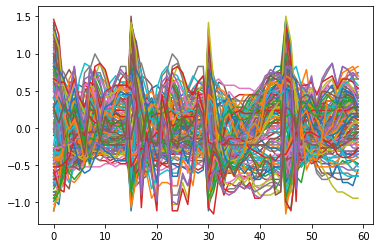

In [91]:
for i in range(data.shape[0]):
    plt.plot(true_samples_scaled[i])

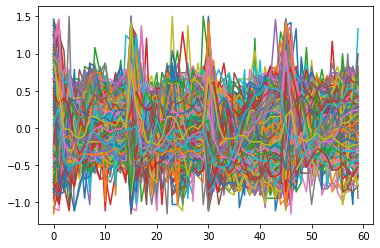

In [92]:
for i in range(500):
    plt.plot(samples_scaled[i])

In [126]:
id = 0

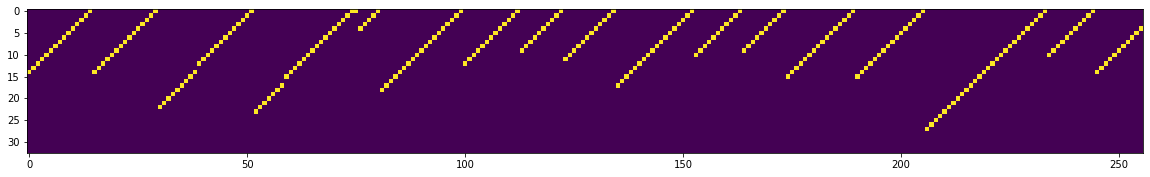

In [137]:
id += 1
plt.figure(figsize=(20, 10))
plt.imshow(F.one_hot(torch.tensor(samples[id]), S).T)

In [128]:
print(count_mistakes(samples))

0.0056640625


In [129]:
data_flat = dataset.data.flatten().cpu().numpy()
samples_flat = samples.flatten()

In [130]:
def get_dist(seq, S):
    L = seq.shape[0]
    one_hot = np.zeros((L, S))
    seq = np.array(seq, dtype=int)
    one_hot[np.arange(L), seq] = 1
    return np.sum(one_hot, axis=0) / L

def hellinger(seq1, seq2, S):
    d1, d2 = get_dist(seq1, S), get_dist(seq2, S)
    return np.sqrt(.5 * np.sum((d1 ** .5 - d2 ** .5) ** 2))

hellinger(data_flat, samples_flat, eval_cfg.data.S)

0.027636434019605142

# Take the samples

In [10]:
num_samples = 100
eval_cfg.sampler.name = 'PCTauLeapingAbsorbingInformed'
eval_cfg.sampler.corrector_step_size_multiplier = 2.
eval_cfg.sampler.balancing_function = "mpf"
sampler = sampling_utils.get_sampler(eval_cfg)
print(sampler)
samples, hist = sampler.sample(model, num_samples, 500,)

499it [01:14,  6.69it/s]


In [11]:
x_hist = hist["x"]
x0_hist = hist["x0"]
c_rate_hist = hist["rc"]

In [12]:
# patch: process the samples by combining model prediction and current location
print(count_mistakes(samples))
is_mask = x_hist[-1] == (S-1)
corrected_samples = is_mask * samples + (1 - is_mask) * x_hist[-1]
print(count_mistakes(corrected_samples))

0.0005078125
0.0005078125


In [15]:
eval_cfg.sampler

balancing_function: mpf
corrector_entry_time: 0.9
corrector_step_size_multiplier: 2.0
eps_ratio: 1.0e-09
initial_dist: absorbing
min_t: 0.01
name: PCTauLeapingAbsorbingInformed
num_corrector_steps: 2
num_steps: 500
reject_multiple_jumps: true

In [39]:
# Using our sampler
num_samples = 10
eval_cfg.sampler.corrector_step_size_multiplier = 1.
eval_cfg.sampler.balancing_function = "barker"
sampler = PCTauLeapingAbsorbingInformed(eval_cfg)
print(sampler)
samples, hist = sampler.sample(model, num_samples, 500,)

499it [00:18, 26.54it/s]


In [40]:
x_hist = hist["x"]
x0_hist = hist["x0"]
c_rate_hist = hist["rc"]

In [41]:
# patch: process the samples by combining model prediction and current location
print(count_mistakes(samples))
is_mask = x_hist[-1] == (S-1)
corrected_samples = is_mask * samples + (1 - is_mask) * x_hist[-1]
print(count_mistakes(corrected_samples))

0.009375
0.009375


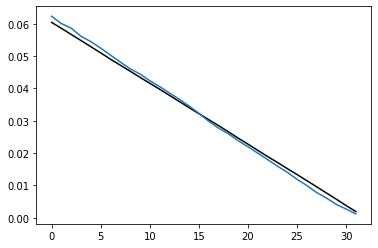

In [15]:
d_sample = get_dist(samples_flat, eval_cfg.data.S-1)
# d_bd_sample = get_dist(bd_samples_flat, eval_cfg.data.S-1)
d_data = get_dist(data_flat, eval_cfg.data.S-1)
plt.plot(d_data, color="k")
plt.plot(d_sample)
# plt.plot(d_bd_sample)

In [20]:
data_flat = dataset.data.flatten().cpu().numpy()
# samples_flat = corrected_samples.flatten()
hellinger(data_flat, samples_flat, eval_cfg.data.S-1)

0.04670345126994198

# Examine the samples

In [21]:
eval_cfg.sampler.corrector_step_size_multiplier

2.0

In [22]:
x_hist = hist["x"]
x0_hist = hist["x0"]
c_rate_hist = hist["rc"]

In [24]:
# np.sum(((samples[id,:-1] - samples[id,1:]) != 1) * (samples[id,:-1] != 0))

In [25]:
l = -1
id = -1

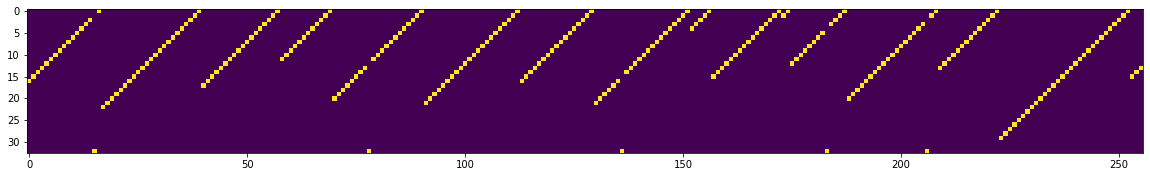

In [27]:
id += 1
plt.figure(figsize=(20, 10))
plt.imshow(F.one_hot(torch.tensor(x_hist[-1, id]), S).T)

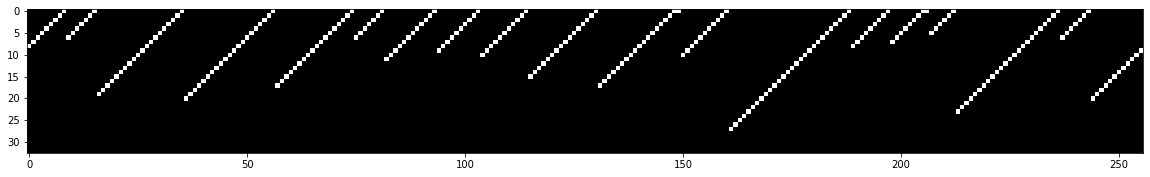

In [40]:
id += 1
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
visualize_diff(ax1, samples[id], corrected_samples[id])

In [197]:
# for l in range(x_hist.shape[0]-1):
#     if ((x_hist[l, id] != x_hist[l+1, id]) * (x_hist[l, id] != S-1)).any():
#         print(l)

51
53
54
55
57
58
59
60
61
63
66
67
71
75
76
77
78
79
80
83
85
86
87
88
89
90
91
94
95
96
98
99
100
102
105
107
108
109
110
116
117
118
119
122
125
127
128
129
130
132
133
136
138
139
140
141
142
143
147
154
155
158
160
161
163
166
167
168
169
172
173
175
178
179
180
182
185
186
187
188
189
190
191
192
193
194
198
199
201
202
203
204
205
206
207
208
210
211
212
213
214
216
219
222
226
227
228
229
230
232
235
236
238
239
242
243
247
248
249
251
252
253
254
255
257
258
259
260
261
262
263
264
265
266
267
268
270
271
272
273
276
277
278
281
282
284
285
288
289
291
293
296
298
299
300
303
304
305
306
307
310
312
314
316
317
319
321
322
323
324
325
327
330
331
332
333
335
336
339
340
346
348
350
351
352
353
354
355
357
358
359
361
362
363
365
366
367
368
371
375
377
378
379
384
385
386
387
389
392
394
395
396
399
402
404
405
406
407
409
410
411
415
416
419
420
421
422
423
426
427
428
429
430
431
432
433
435
436
437
440
441
442
443
444
449
450
454
455
456
457
462
464
465
467
468
469
470
471


In [41]:
l = 50

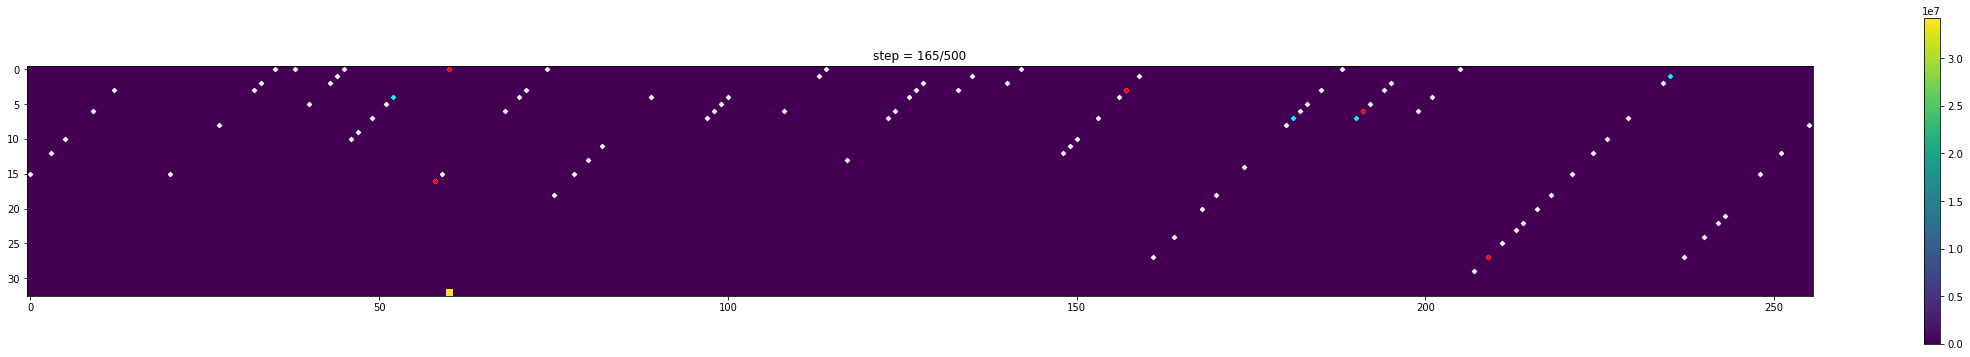

In [92]:
l += 1

fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(40, 6))
# visualize_diff(ax1, x_hist[l, id], x_hist[l+1, id])
ax2.set_title("step = {}/{}".format(l, eval_cfg.sampler.num_steps))
cr = c_rate_hist[l, id].T
# one_hot = F.one_hot(torch.tensor(x_hist[l, id]), S).T.cpu().numpy()
cat = ax2.imshow(cr, vmin=cr.min(), vmax=cr.max())

x = x_hist[l, id]
y = x_hist[l+1, id]
diff_loc = x != y

scale = (S-1) / eval_cfg.sampler.corrector_step_size_multiplier / 500
# ax2.plot(S - 1 - cr[-1,:] * scale, color='c', alpha=.4)
ax2.scatter(np.arange(cr.shape[1])[x<S-1], x[x<S-1], color="w", marker="D", s=10)
ax2.scatter((np.arange(cr.shape[1]))[diff_loc * (x<S-1)], x[diff_loc * (x<S-1)], color="r", marker="D", s=10)
ax2.scatter((np.arange(cr.shape[1]))[diff_loc * (y<S-1)], y[diff_loc * (y<S-1)], color="cyan", marker="D", s=10)
fig.colorbar(cat, ax=ax2)
fig.set_facecolor('white')

In [419]:
(y*diff_loc)[y<S-1]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, 23,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [175]:
cr[-1,:]

array([2.8319006 , 0.        , 2.80219769, 0.        , 0.        ,
       3.3007226 , 0.        , 0.        , 0.        , 2.82313704,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 3.11396408,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 3.10531306,
       0.        , 0.        , 2.81148458, 2.80131197, 2.80131292,
       0.        , 2.80131221, 0.        , 0.        , 0.        ,
       3.2999599 , 0.        , 0.        , 0.        , 3.29441381,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 3.13194895, 0.     

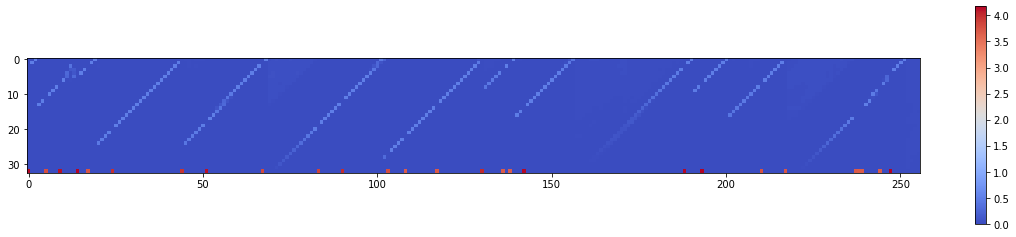

In [150]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cr = c_rate_hist[l, id].T
cat = ax1.imshow(cr, vmin=cr.min(), vmax=cr.max(), cmap="coolwarm")
fig.colorbar(cat, ax=ax1)

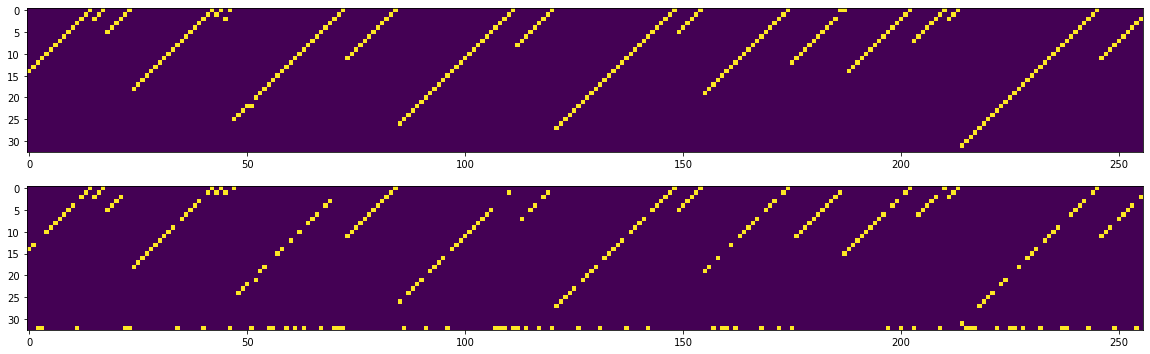

In [447]:
l -= 1
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 6))

# Plotting on the first axis
ax1.imshow(F.one_hot(torch.tensor(x0_hist[l, id]), S).T)
ax2.imshow(F.one_hot(torch.tensor(x_hist[l, id])).T)

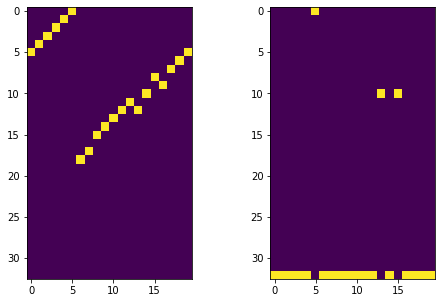

In [194]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

# Plotting on the first axis
ax1.imshow(F.one_hot(torch.tensor(x0_hist[id, 0, 80:100]), S).T)
ax2.imshow(F.one_hot(torch.tensor(x_hist[id, 0, 80:100])).T)
fig.set_facecolor('white')

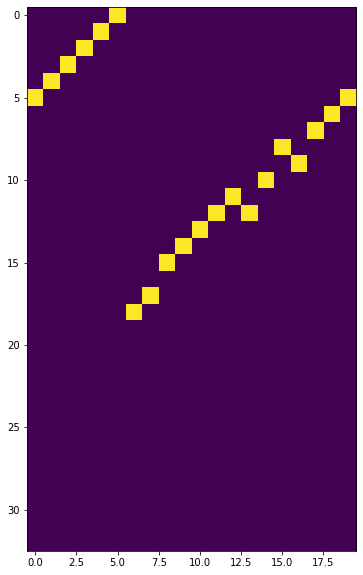

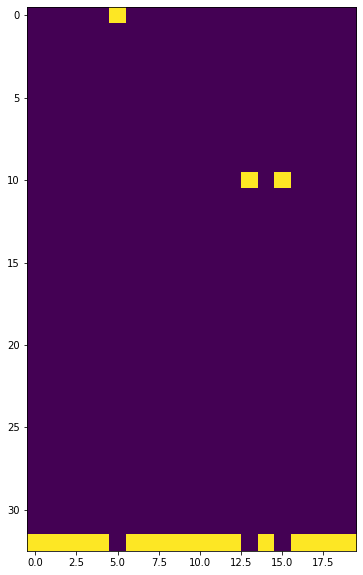

In [184]:
# id += 1
plt.figure(figsize=(20, 10))
plt.imshow(F.one_hot(torch.tensor(x0_hist[id, 0, 80:100]), S).T)
plt.figure(figsize=(20, 10))
plt.imshow(F.one_hot(torch.tensor(x_hist[id, 0, 80:100])).T)